# Import library, create environment and quick review on the numbers info

In [1]:
#import gym library
import gym
#Import numpy and libraries for data processing and calculation
import numpy as np
import math

#Plotting library
import matplotlib.pyplot as plt

#Kbins for later bin create
from sklearn.preprocessing import KBinsDiscretizer

#Other library
import time
import random
from typing import Tuple

#Implement the cart pole environment
env = gym.make('CartPole-v0').env

#Quick review on action spaces number and state space number of the Cart pole environment
print("Number of action:",env.action_space)
print("Number of state:",env.observation_space)

Number of action: Discrete(2)
Number of state: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


# a) Random search method

1. Function of action decision making based on the vector multiplication result of parameter and observation (< 0: go left, > 0: go right)

In [2]:
def action_decision(parameter,obs):
    if (np.matmul(parameter,obs) < 0):
        return 0
    else:
        return 1

2. Function of making an episode, then return the episode's reward (for each timestep the pole still straight, the reward +=1) to evaluate the episodes performance

In [3]:
#Define function that run 1 episode with given timestep
def episode_run(env, parameter,timesteps):
    #Reset an observation to be random situation
    obs = env.reset() 
    
    #Initialize reward
    total_rw = 0
    
    #Loop through 'timestep' iteration of action to check for the performance, break the loop when the pole fall
    for i in range(timesteps):
        
        #Draw the action based on the vector multiplication
        action = action_decision(parameter,obs)
        #Update the observation, gained reward, done boolean and info after that action
        obs, rw, done, info = env.step(action)
        #Update total episode's reward after the action
        total_rw = total_rw + rw
        
        #Check if the pole is fallen after the timestep. If yes, break the loop
        if (done == True):
            break
    
    return total_rw

3. Main function of random search - trying random weight to run episode and pick the weight with best performance (highest reward)

In [4]:
def random_search():
    #Initialize variable to store best performance reward (from episode) and best parameter
    best_para = 0
    best_rw = 0

    #Loop through numbers of episode with random parameter set (array of 4 observation), looking for the best performance
    ep_numb = 1000     #episode number
    for i in range(ep_numb):
        parameter = np.random.rand(4)*2 - 1
        rw = episode_run(env,parameter,timesteps = 200)
        #Checking if the epoch is the best performance or not by comparing it's reward to current best reward
        if (rw > best_rw):

            #If yes, update the new best weight and reward
            best_para = parameter
            best_rw = rw

        #Assume that the problem is solve if the episode can hold the pole for 200 timestep
        #When the situation comes, break the loop and consider it is the best given solution
        if (rw == 200):            
            #Return episode needed for success (break)
            return i
            break
    print(best_para,best_rw)

4. Calculate the average episode the method takes to solve the problem (200 timestep of not falling) from 100 times 

In [5]:
#Array to store all the number of episode the method need to solve the problem for each time of trying (100 tries)
episode_needed =[]

#Loop through 100 time of random search method
for i in range(100):
    episode_needed.append(random_search())

#Print out the average episode needed for 100 tries of solving problem using random search
print("Average episode for success for 100 train times:",sum(episode_needed)/100)

Average episode for success for 100 train times: 12.18


5. Create a graph of frequency of 

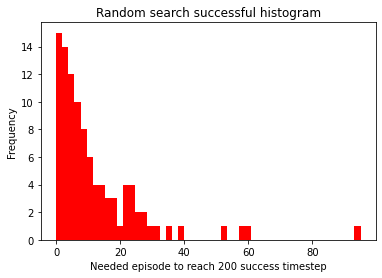

In [6]:
#Draw a histogram of frequency of episode for successful for each train
plt.hist(episode_needed,50, facecolor='r')
plt.xlabel('Needed episode to reach 200 success timestep')
plt.ylabel('Frequency')
plt.title('Random search successful histogram')
plt.show()

# b) Q-learning method to solve the cartpole problem

In [7]:
#Initialize the environment
env = gym.make('CartPole-v0')

1. Divided state space into discrete bucket (to convert continuous observation into discrete observation => transform the problem to finite state to apply Q-learning)

In [8]:
#Divide continuous state space into discrete bucket
discrete_bin = (6,12)

#Intake lower bound and upper bound
boundlow = [env.observation_space.low[2],-math.radians(50)]
boundup = [ env.observation_space.high[2],math.radians(50)]

#Function that divide observation by it's angle and pole velocity into 6 and 12 bins respectively, makes the return to be tuple
def divide_into_bucket( _ , __ , angle, pole_velocity ):
    
    #Using the KbinDiscretizer to divide observation by pole angle and pole velocity into 6 and 12 bins respectively
    bin = KBinsDiscretizer(n_bins=discrete_bin, encode='ordinal', strategy='uniform')
    bin.fit([boundlow, boundup ])
    return tuple(map(int,bin.transform([[angle, pole_velocity]])[0]))

2. initialize 3D Q-table, create a policy to make a move and update Q-value function

In [9]:
#Store every combination of (state + action)'s long term reward
Qtable = np.zeros(discrete_bin + (env.action_space.n,))
Qtable.shape

#Create a policy that taking action has a highest Q-value return for each state (using Q-table) using argmax
def policy(state):
    return np.argmax(Qtable[state])

#Create a function that update new Qvalue for an action in the state space using the given formula (and makes the return to be float)
#Q(state,action) ← (1−α)Q(state,action) + α(reward+γmax(a)Q(next state,all actions))
def Qval_new(rw,newstate):
    #Input the next max Q-value from state space
    next_max = np.max(Qtable[newstate])
    
    #update the new Qvalue for the cell in table
    new_Q_value = rw + next_max
    
    #Return
    return float(new_Q_value)

3. Decay functions to tune the learning rate of the action

In [10]:
#Decay the learning rate function to weight old Q-value with the new one
#It'll make the it learn faster at the begin and slower at the end
def alpha(n):
    return float(max(0.01, min(1.0, 1.0 - math.log10((n + 1) / 25))))

#Exploration rate function for better exploring the state space by creating a proportion of random action
def exploration_rate(n):
    """Decaying exploration rate"""
    rate = float(max(0.1, min(1, 1.0 - math.log10((n  + 1) / 25))))
    return rate

4. Training step and render to see the result (if necessary)

In [11]:
#Running 4000 trainings
array_timestep = []
for i in range(4000):
    
    # Separate continuous state to discrete value
    state = divide_into_bucket(*env.reset())
    done = False
    timestepmade = 0
    while (done!=True):    
        #Action
        action = policy(state)
        
        #Using exploration rate (mentioned above) to explore the state space by bring in various random combination
        if np.random.random() < exploration_rate(i) : 
            action = env.action_space.sample()
            
        #Take output from action
        obs, rw, done, _ = env.step(action)
        newstate = divide_into_bucket(*obs)
        
        #Calculate learning rate
        alphaa = alpha(i)
        
        #Update new Qvalue for an action in the state space using the given formula using the mentioned learning rate
        next_max = Qval_new(rw,newstate)
        oldvalue = Qtable[state][action]
        Qtable[state][action] = (1-alphaa)*oldvalue + alphaa*next_max
        state = newstate
        timestepmade+=1
        #env.render()
    array_timestep.append(timestepmade)
#print(array_timestep)
print("Done training")

Done training


5. Evaluate the Q-table in solving 100 episode of problem

In [12]:
array_timestep_realrun = []
#Solve 100 episode and evaluate the result
for i in range(100):
    # Separate continuous state to discrete value
    state = divide_into_bucket(*env.reset())
    done = False
    timestepmade = 0
    while (done!=True):    
        #Action
        action = policy(state)
        timestepmade+=1
        #Take output from action
        obs, rw, done, _ = env.step(action)
        state = divide_into_bucket(*obs)
        #env.render()
    array_timestep_realrun.append(timestepmade)
    
#Print the result, the result should be all 200 (the number of pole balance timestep that is considered as success)
print(array_timestep_realrun)
print("Done testing")

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
Done testing


5. Learning speed visualization

Text(0, 0.5, 'Successful timestep made (max 200)')

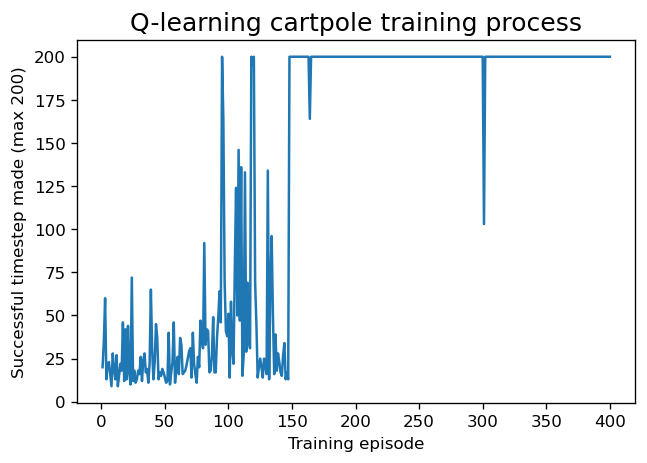

In [13]:
from matplotlib.pyplot import figure

#Create variable x to store 400 first training episodes number from 1 to 400 (the part we want to visualize over 4000 episodes each training)
x = []
for i in range (1,401):
    x.append(i)
    
#y is the result of first 400 episodes of the training
y = array_timestep[0:400]

#Graph
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
ax.plot(x, y)

#Name the elements
ax.set_title('Q-learning cartpole training process', fontsize=15)
ax.set_xlabel('Training episode', fontsize=10)
ax.set_ylabel('Successful timestep made (max 200)', fontsize=10)